# Azure Function HTTP Triggers  

## Docker Image including Azure Functions Core Tools and Azure CLI  

Docker File:  

In [1]:
print('''FROM ubuntu:bionic

ARG DEBIAN_FRONTEND=noninteractive
ARG TZ="Europe/Madrid"

# Azure Credentials
ENV username=user
ENV password=pass

RUN apt update -y && apt install -y sudo dialog curl wget git libicu-dev vim \
    && sudo apt install -y software-properties-common && sudo add-apt-repository -y ppa:deadsnakes/ppa \
    && apt install -y python3.9 \
    && sudo apt-get -y install python3.9-venv && curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py \
    && python3.9 get-pip.py && wget -q https://packages.microsoft.com/config/ubuntu/20.04/packages-microsoft-prod.deb \
    && sudo dpkg -i packages-microsoft-prod.deb \
    && sudo apt-get update && sudo apt-get -y install azure-functions-core-tools-4 \
    && echo '' >> requirements.txt \
    && curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash''') 

FROM ubuntu:bionic

ARG DEBIAN_FRONTEND=noninteractive
ARG TZ="Europe/Madrid"

# Azure Credentials
ENV username=user
ENV password=pass

RUN apt update -y && apt install -y sudo dialog curl wget git libicu-dev vim     && sudo apt install -y software-properties-common && sudo add-apt-repository -y ppa:deadsnakes/ppa     && apt install -y python3.9     && sudo apt-get -y install python3.9-venv && curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py     && python3.9 get-pip.py && wget -q https://packages.microsoft.com/config/ubuntu/20.04/packages-microsoft-prod.deb     && sudo dpkg -i packages-microsoft-prod.deb     && sudo apt-get update && sudo apt-get -y install azure-functions-core-tools-4     && echo '' >> requirements.txt     && curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash


## Azure Functions Setup  

The image classifier comes from this project:  git clone https://github.com/Azure-Samples/functions-python-pytorch-tutorial.git  

In particular, these files are deployed to this Azure Function:  
* resources/predict.py    
* resources/labels.txt  


HTTP Requests sent to the function are handled by \_\_init\_\_.py:  

```
import logging
import azure.functions as func
import json

# Import helper script
from .predict import predict_image_from_url

def main(req: func.HttpRequest) -> func.HttpResponse:
    image_url = req.params.get('img')
    logging.info('Image URL received: ' + image_url)

    results = predict_image_from_url(image_url)

    headers = {
        "Content-type": "application/json",
        "Access-Control-Allow-Origin": "*"
    }

    return func.HttpResponse(json.dumps(results), headers = headers)

```   


We will create a Python 3.9 virtual environment to install dependencies required by our Function:  

```
python3.9 -m venv .venv
source .venv/bin/activate
pip install --no-cache-dir -r requirements.txt  
```  

where requirements.txt contains:  

```
azure-functions
requests
-f https://download.pytorch.org/whl/torch_stable.html
torch==1.12.0+cpu
torchvision==0.13.0+cpu
```  

Create HTTP Trigger Function: classify  

```func new --name classify --template "HTTP trigger" --language python  ```  

A function can be tested locally running:  

```func start  ```    



### Move code to function directory:  

```cp src/* classify  ```  

## Azure Function Deployment:


1. Create a random ID  

```randomId=$(cat /dev/urandom | env LC_ALL=C tr -dc 'a-z0-9' | fold -w 11 | head -n 1)```  

In this run, the value was: e5u66mj92zr  

2. Log on to Azure  

```az login -u $username -p $password ```  
```az account set --subscription e0b9cada-61bc-4b5a-bd7a-52c606726b3b  ```  

3. Create Resource Group or Use an existing one  

```resource=IE_ST_BCSAI_DUD_STUDENT```  

```
resource=$(az group list --query "[0].name" --output tsv)  
az group create --name $resource --location eastus
```  

4. Create Storage Account or Use an existing one  

```storageaccount=iestdudbstudent0001```  
```  
az storage account create \
    --name lesson11st$randomId \
    --resource-group $resource \
    --sku Standard_LRS
```  

5. Create Function App named MyHttpApp$randomId. A function App may contain multiple functions  

```  
az functionapp create --consumption-plan-location eastus \
     --runtime python \
     --runtime-version 3.9 \
     --functions-version 4 \
     --resource-group $resource \
     --name MyHttpApp$randomId \
     --os-type linux \
     --storage-account ${storageaccount}
```  

6. Publish your Function App to Azure:  

```  
func azure functionapp publish MyHttpApp$randomId --python
```  


This command may take +15 minutes to complete.



The last message should contain an "Invoke URL"  

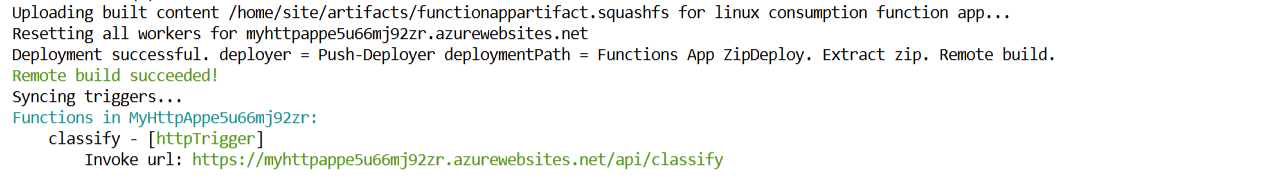  

```
Functions in MyHttpAppe5u66mj92zr:
    classify - [httpTrigger]
        Invoke url: https://myhttpappe5u66mj92zr.azurewebsites.net/api/classify
```  

Log on to Azure Portal  

Assets related to your Azure Function include:  

- App Service Plan  
- Storage Account  
- Application Insights  
- Function App  

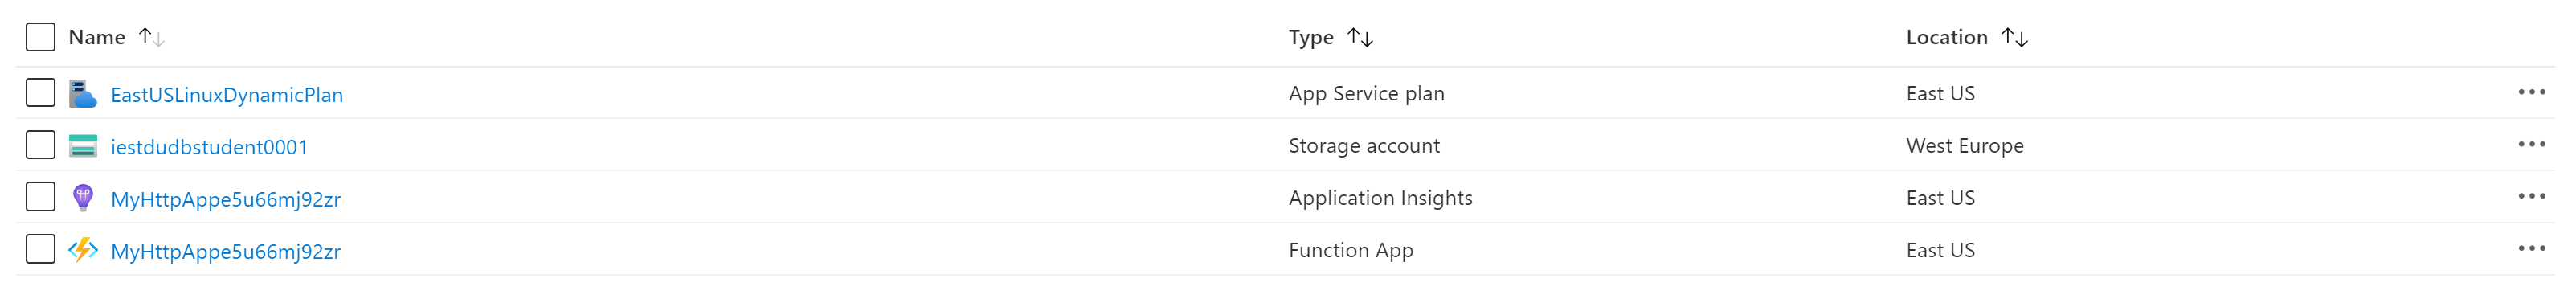  


Create a new key and note it down:  
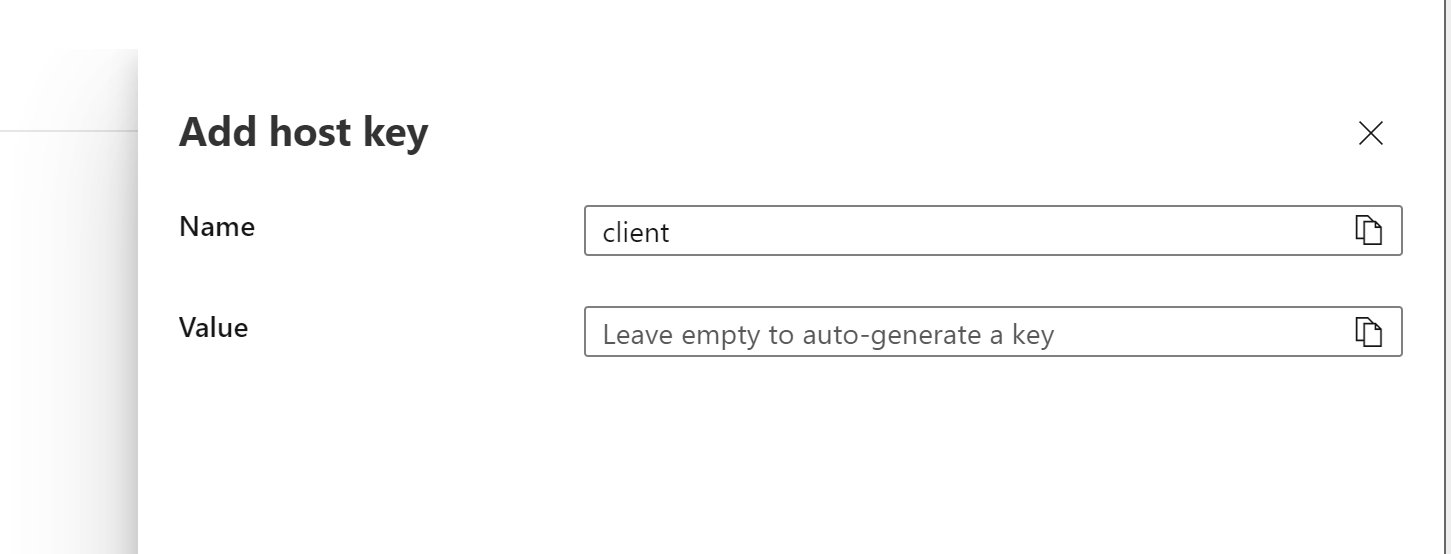  

eb9Y4GyDwqfd3xoGhE0O8OkERoIXp0iq5xm9vVeE97JvAzFuBkSqPg==  

Now, click on:  

Functions > classify > Code + Test  

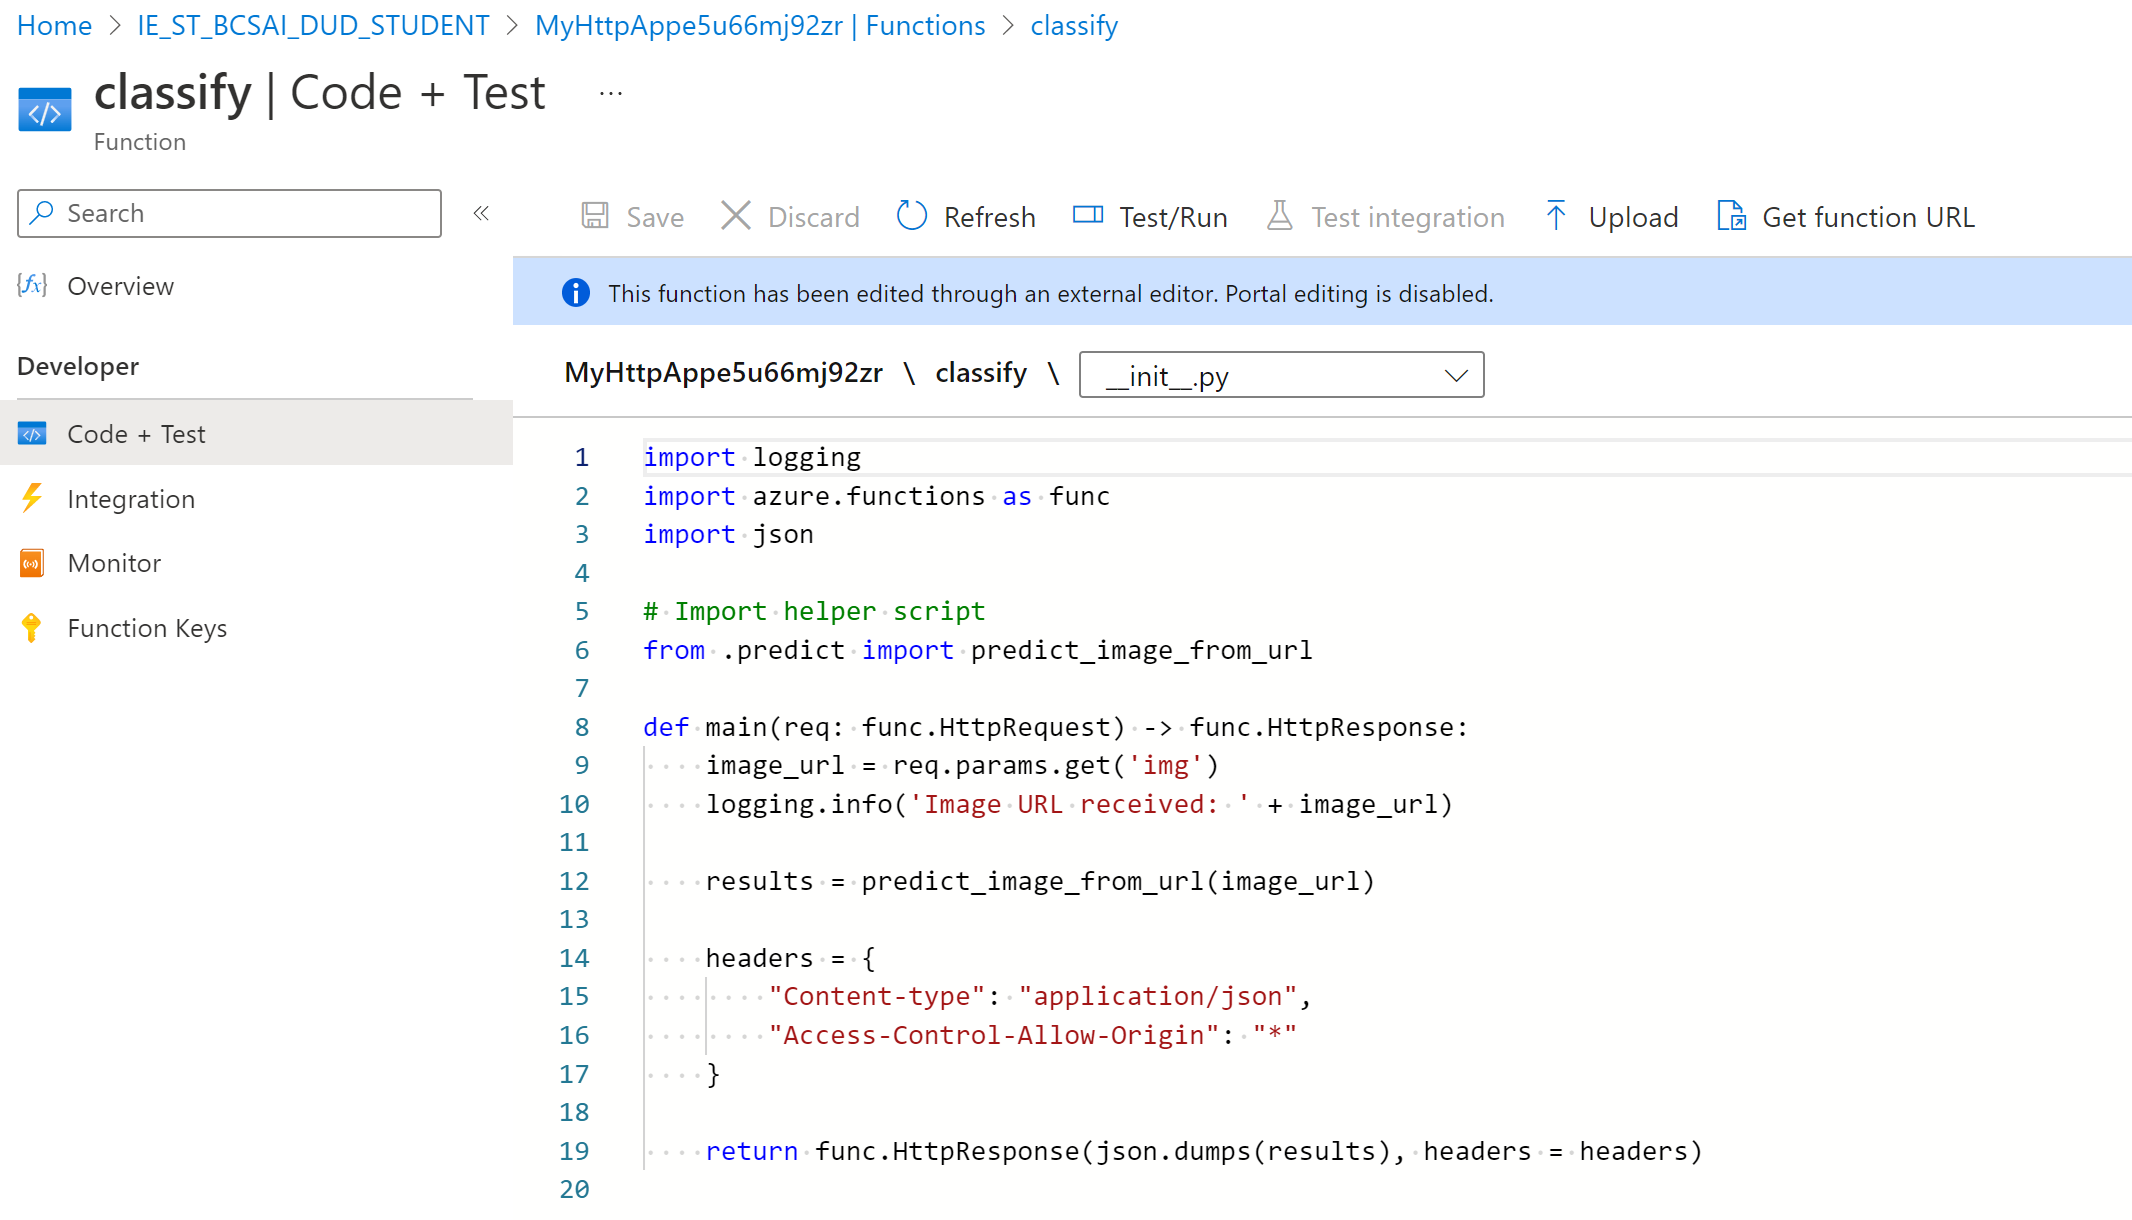  


Click on Test/Run and provide:  
1. "client" as your Key  
2. Image URL as a Query Parameter  

Input:  
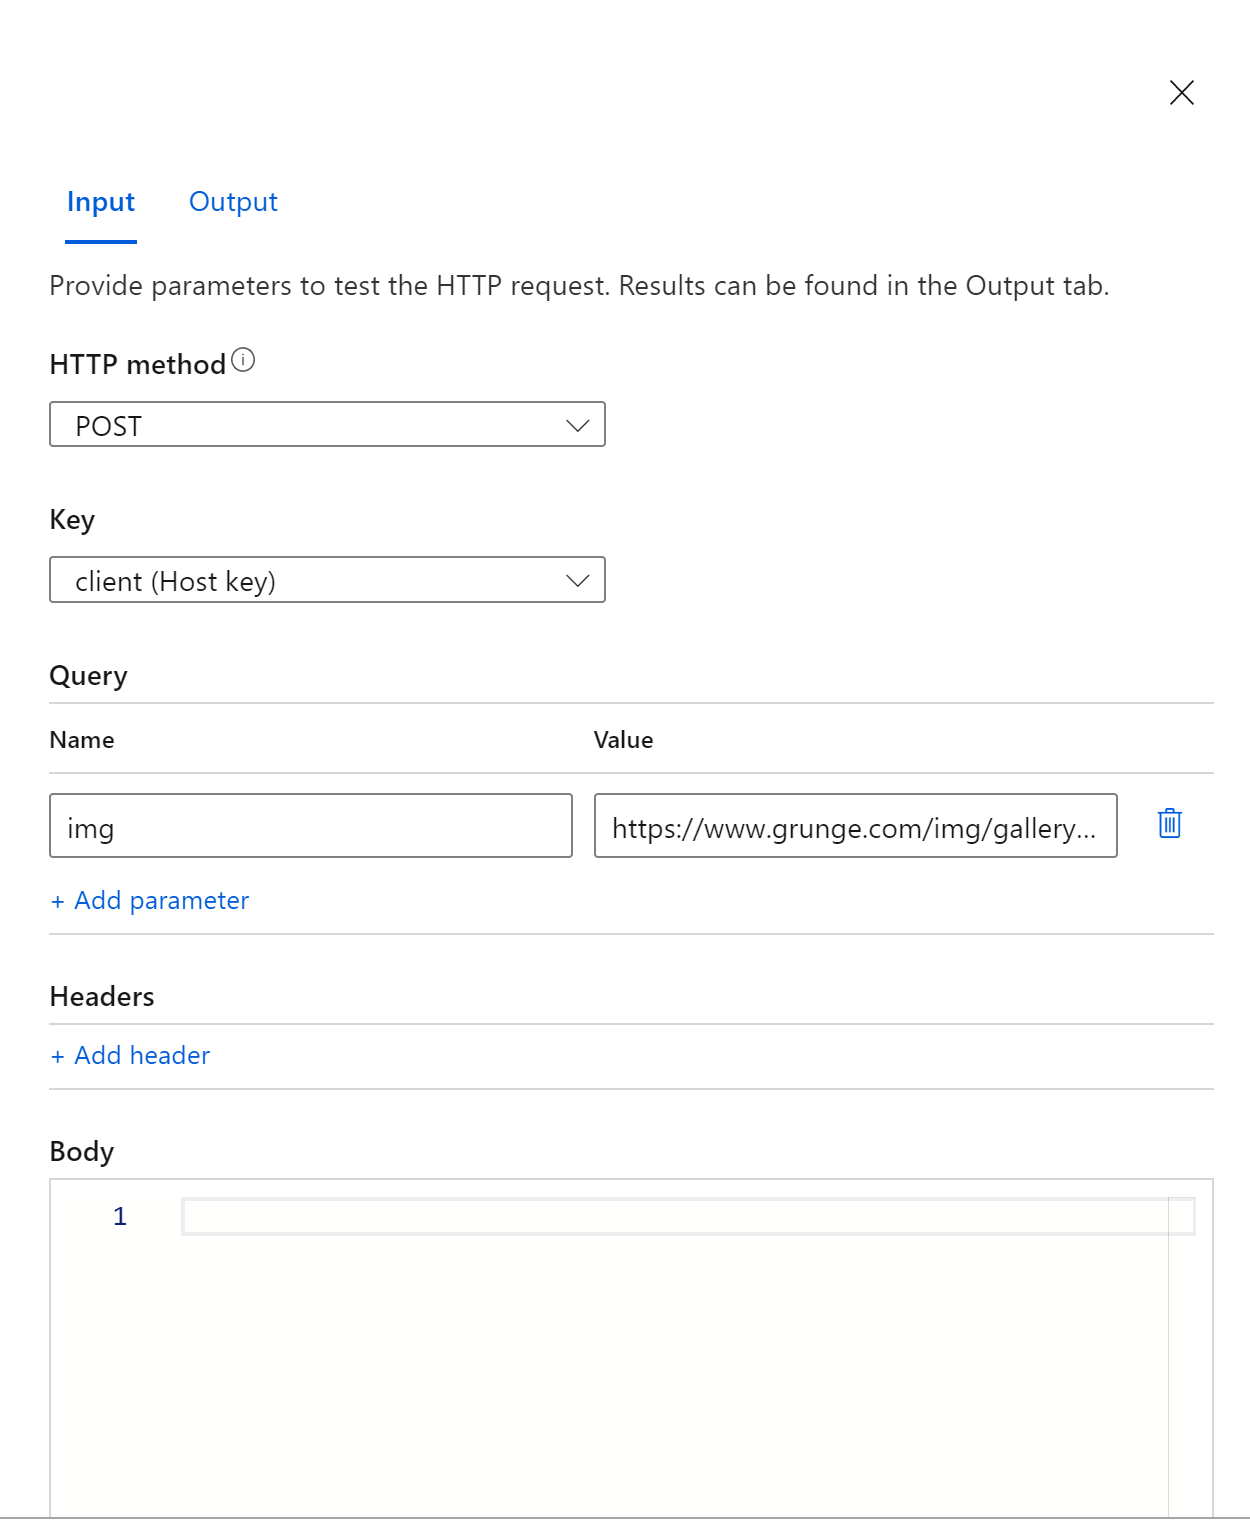  

Output:  

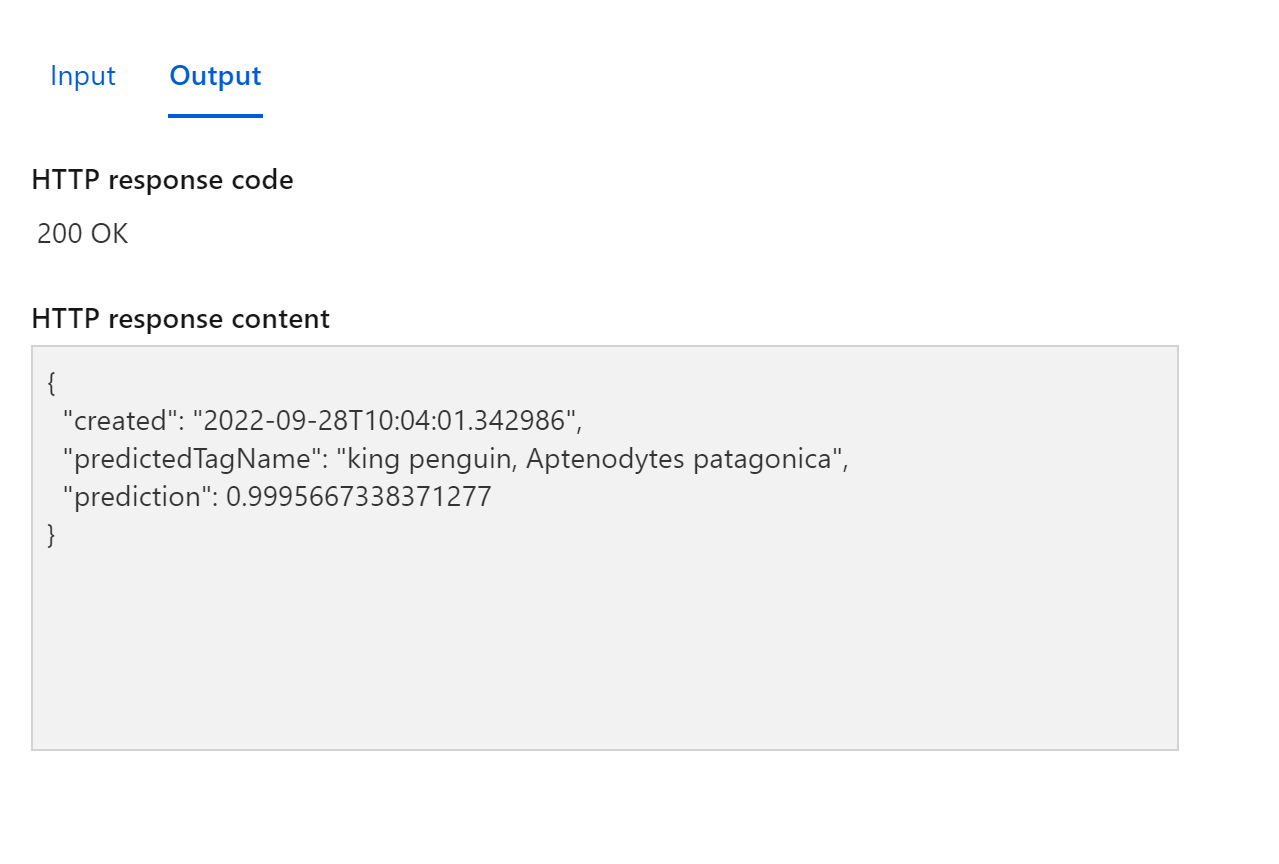  

Logs:  

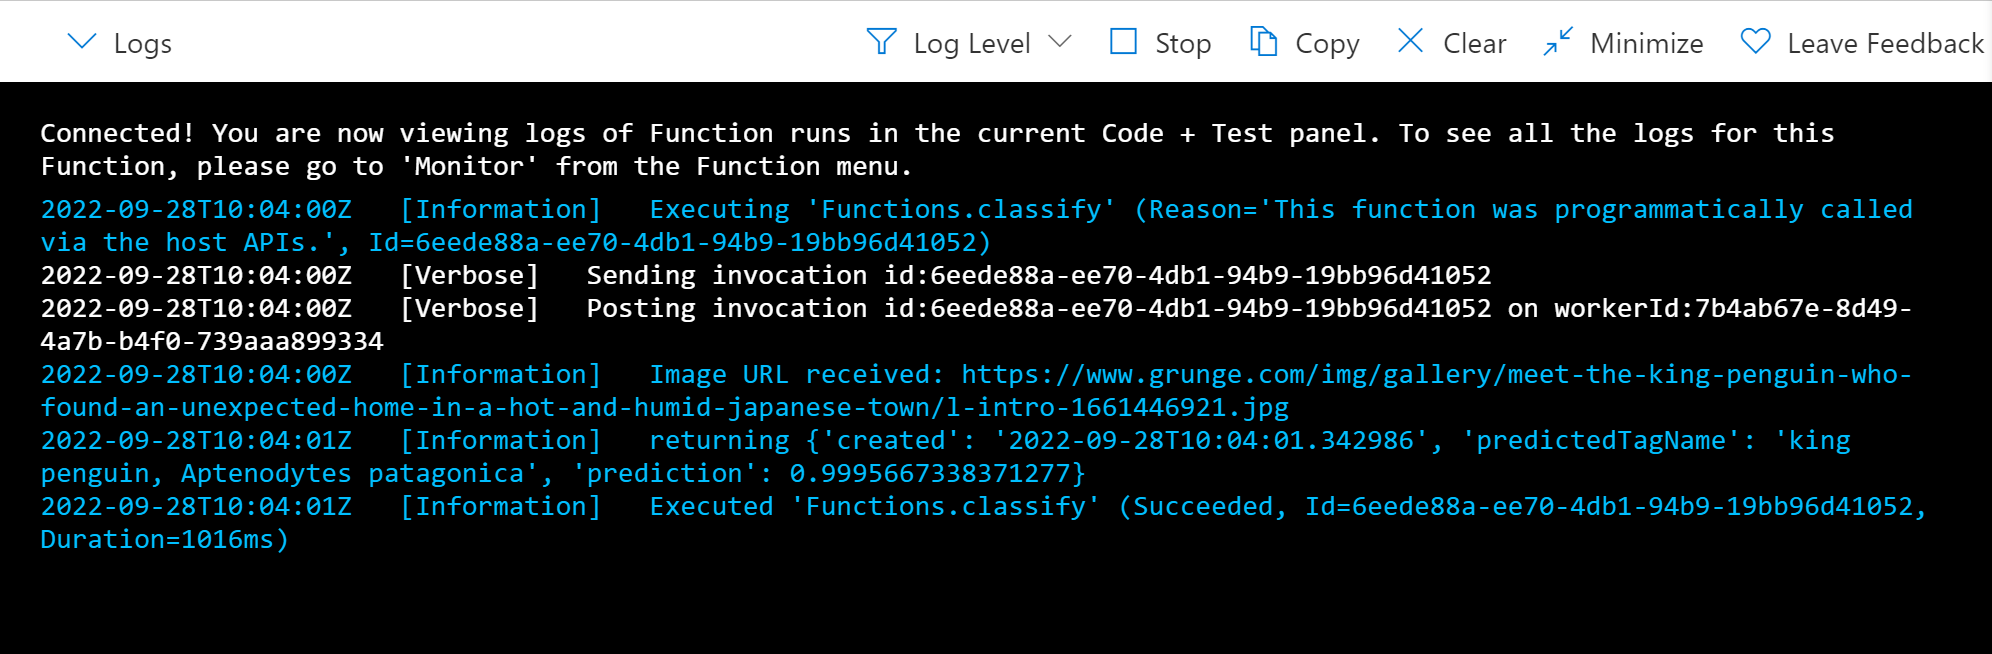  


To run the function from your browser, you must Get the function URL first:  

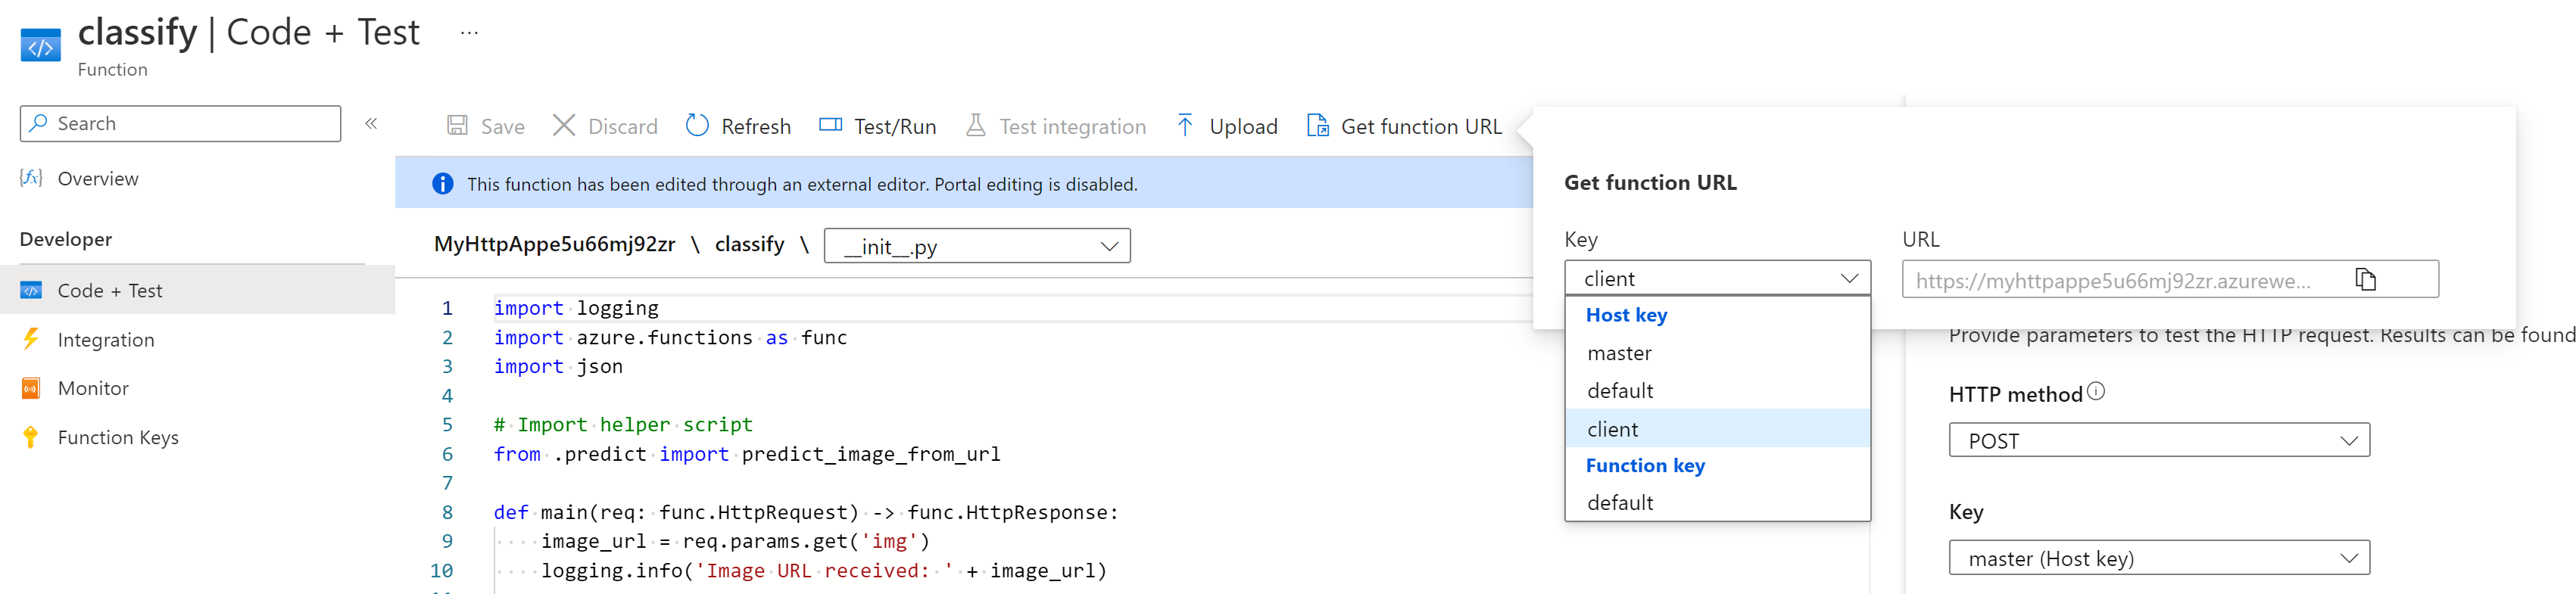  

The add your target image as an additional query string paramter, for example:  

https://myhttpappe5u66mj92zr.azurewebsites.net/api/classify?code=eb9Y4GyDwqfd3xoGhE0O8OkERoIXp0iq5xm9vVeE97JvAzFuBkSqPg==&img=https://www.grunge.com/img/gallery/meet-the-king-penguin-who-found-an-unexpected-home-in-a-hot-and-humid-japanese-town/l-intro-1661446921.jpg  

Function Authorization Level  

The [authorization level](https://learn.microsoft.com/en-us/azure/azure-functions/functions-bindings-http-webhook-trigger?tabs=in-process%2Cfunctionsv2&pivots=programming-language-python#http-auth) is a string value that indicates the kind of authorization key that's required to access the function endpoint. For an HTTP triggered function, the authorization level can be one of the following values:  

* anonymous: No API key is required  
* function: A function-specific API key is required. This is the default value when a level isn't specifically set  
* admin: The master key is required  


1. Make sure your current directory is functions-python-pytorch-tutorial/start/  

2. Make a copy of the classify Azure Function code:  


```
func new --name classifyanonymous --authlevel anonymous --template "HTTP trigger" --language python
```

3. Deploy model files:  


```
cp classify/predict.py classifyanonymous/
cp classify/labels.txt classifyanonymous/
cp classify/__init__.py classifyanonymous/
```  

The status should be this:  

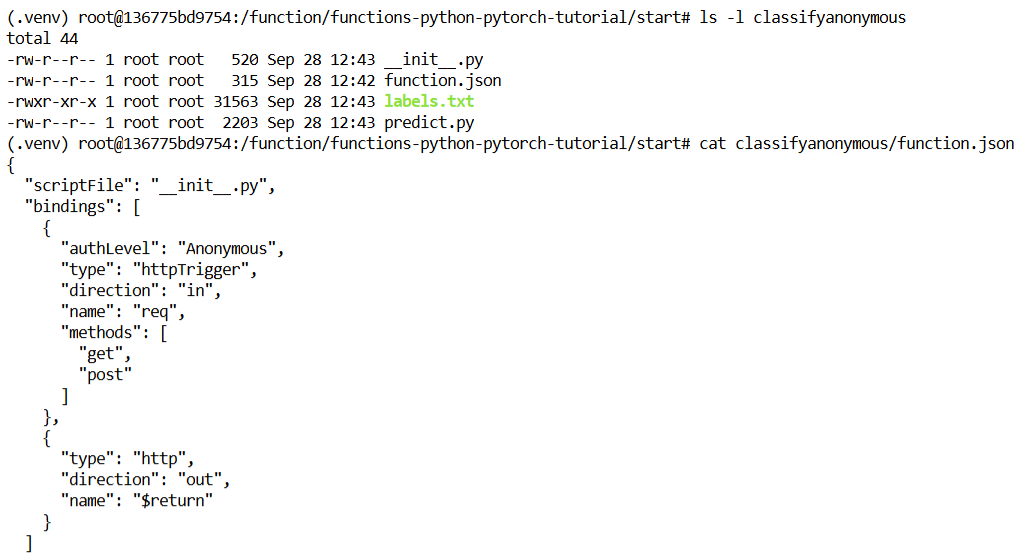  


4. Create the Azure Function App  

```
az functionapp create --consumption-plan-location eastus \
     --runtime python \
     --runtime-version 3.9 \
     --functions-version 4 \
     --resource-group $resource \
     --name MyHttpApp$randomId \
     --os-type linux \
     --storage-account ${storageaccount}
```  


5. Publish your Function App to Azure:  

```  
func azure functionapp publish MyHttpApp$randomId --python
```  

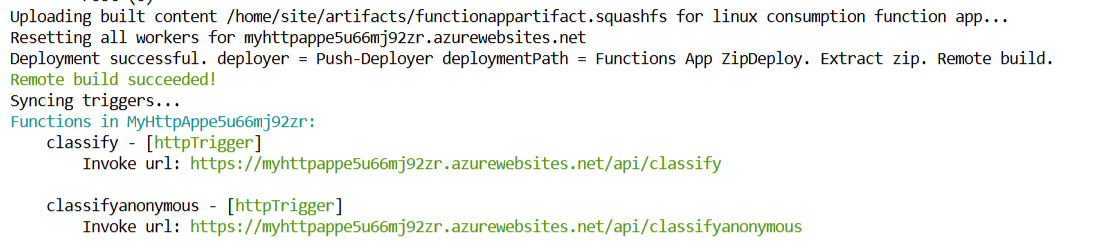  

```
Functions in MyHttpAppe5u66mj92zr:
    classify - [httpTrigger]
        Invoke url: https://myhttpappe5u66mj92zr.azurewebsites.net/api/classify

    classifyanonymous - [httpTrigger]
        Invoke url: https://myhttpappe5u66mj92zr.azurewebsites.net/api/classifyanonymous
```  

https://myhttpappe5u66mj92zr.azurewebsites.net/api/classifyanonymous?img=https://www.grunge.com/img/gallery/meet-the-king-penguin-who-found-an-unexpected-home-in-a-hot-and-humid-japanese-town/l-intro-1661446921.jpg

On Azure Portal you should now see the 2 Functions:  

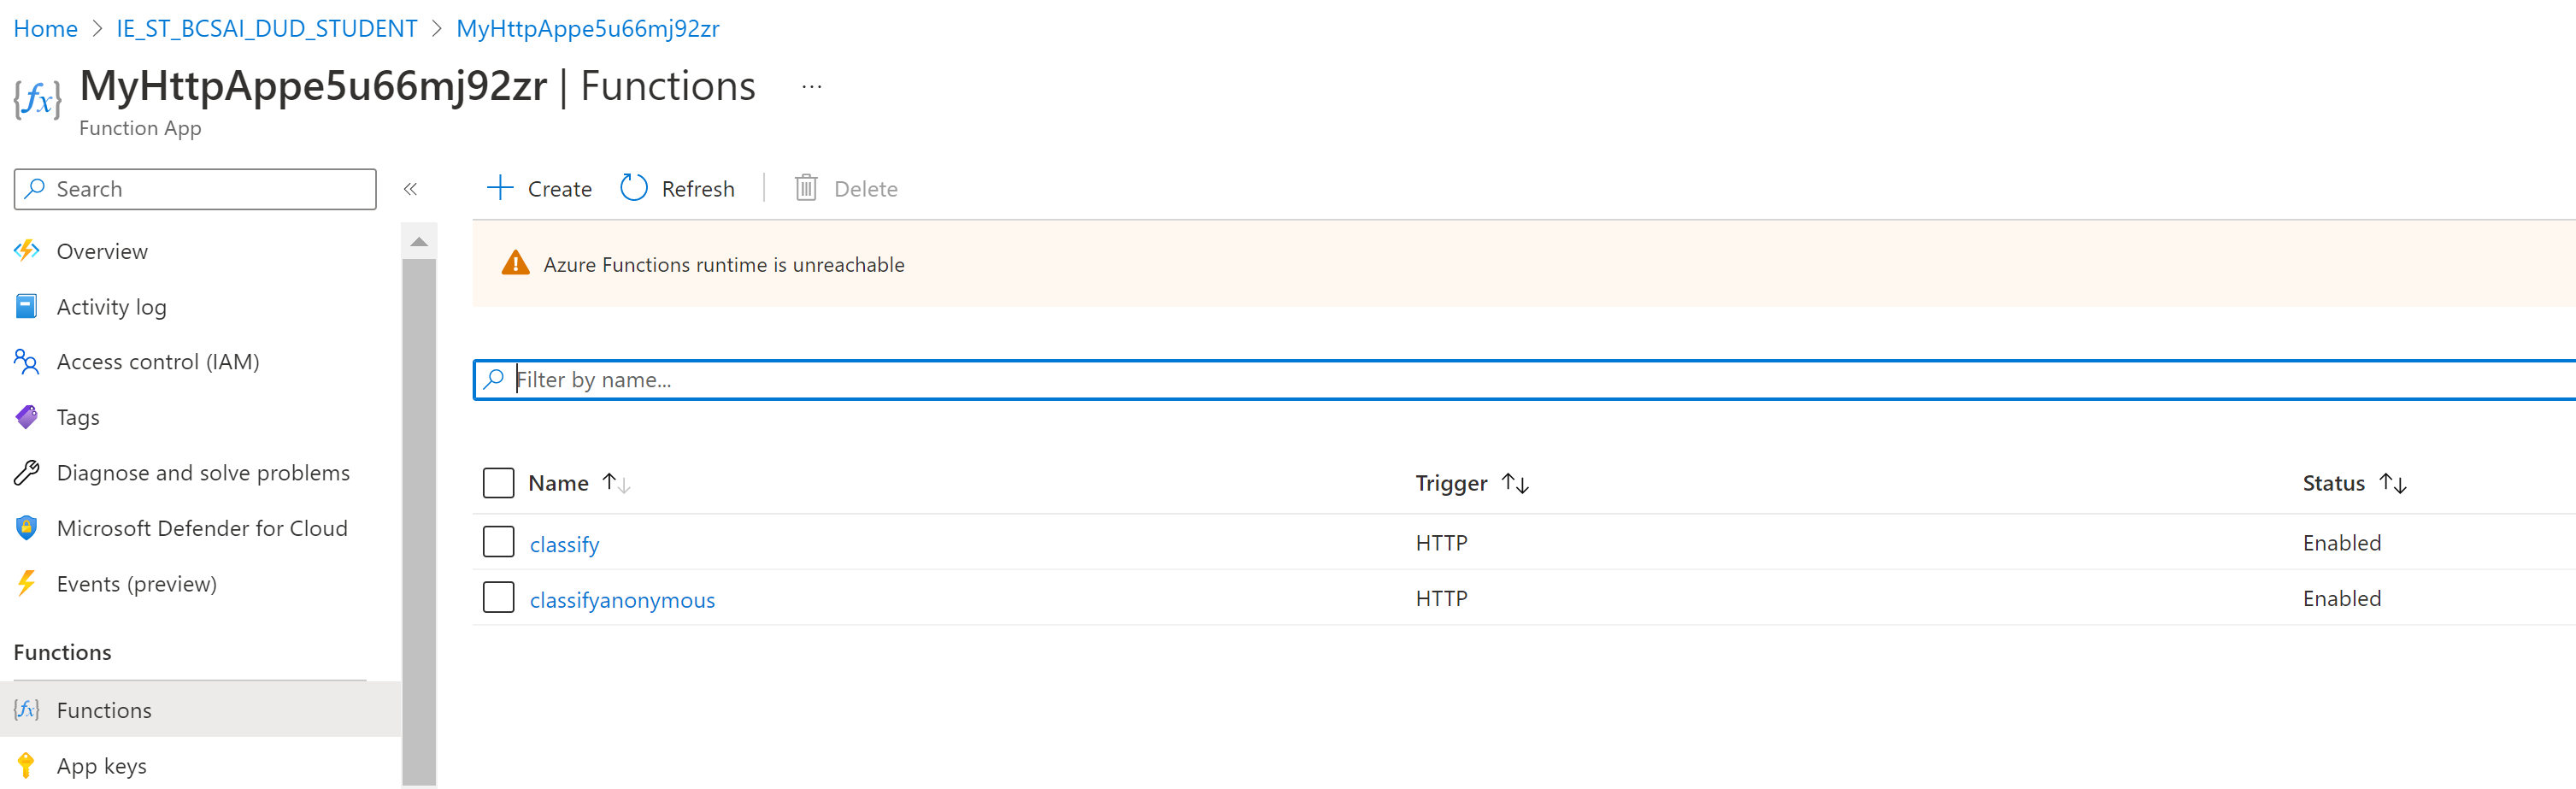  